In [51]:


import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import backtrader as bt
from zipfile import ZipFile
import json
from datetime import *
import logging
from IPython import display

logger = logging.getLogger('[VolProfile]')
logger.setLevel(logging.INFO)

debug_logger = logging.getLogger('[DebugBacktest]')
debug_logger.setLevel(logging.DEBUG)

# create console handler and set level to debug
ch = logging.StreamHandler()
ch.setLevel(logging.INFO)

fh = logging.FileHandler('backtest.log', mode='w')
fh.setLevel(logging.DEBUG)

# create formatter
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')

# add formatter to ch
ch.setFormatter(formatter)

fh.setFormatter(formatter)

if not logger.handlers:
    # create the handlers and call logger.addHandler(logging_handler)
    logger.addHandler(ch)
    
if not debug_logger.handlers:
    debug_logger.addHandler(fh)

In [52]:
year = 2022
month = 3
interval = '15m'

In [53]:
%run -i ../binance-data/download-aggTrade.py -s BTCUSDT -t spot -skip-daily 1 -y $year -m $month

fetching 1 symbols from exchange
Found 1 symbols
[1/1] - start download monthly BTCUSDT aggTrades 

file already exists! E:\Programming\volprofile\binance-data\../data/spot/monthly/aggTrades/BTCUSDT/BTCUSDT-aggTrades-2022-03.zip


In [54]:
%run -i ../binance-data/download-kline.py -s BTCUSDT -t spot -i $interval -skip-daily 1 -y $year -m $month

Found 1 symbols
[1/1] - start download monthly BTCUSDT klines 

file already exists! E:\Programming\volprofile\binance-data\../data/spot/monthly/klines/BTCUSDT/15m/BTCUSDT-15m-2022-03.zip


In [55]:
%run -i ../scripts/poc_generator.py -y $year -m $month

file already exists! ../data/poclist/poclist-2022-03.json


In [56]:
npoc_list = []
with open(f'../data/poclist/poclist-{year}-{month}.json') as f:
    npoc_list = json.load(f)
df_npoc = pd.DataFrame(npoc_list)
df_npoc['date'] = pd.to_datetime(df_npoc['date'])
df_npoc = df_npoc.set_index('date')
df_npoc = df_npoc.tz_localize(None)
df_npoc['valid'] = 1
logger.info(df_npoc.head())

2023-09-09 09:52:58,846 - [VolProfile] - INFO -                 npoc       vah       val  valid
date                                           
2022-03-01  43497.98  44009.98  43049.98      1
2022-03-02  44198.09  44390.09  43750.09      1
2022-03-03  43448.28  44056.28  42552.28      1
2022-03-04  41366.00  41782.00  40566.00      1
2022-03-05  38995.59  39247.59  38799.59      1


In [57]:
#to download the file
#py download-kline.py -t spot -s BTCUSDT -i 15m -y 2023 -m 05 -skip-daily 1 
df = pd.read_csv(ZipFile(f"../data/spot/monthly/klines/BTCUSDT/15m/BTCUSDT-15m-{year}-{month}.zip").open(f"BTCUSDT-15m-{year}-{month}.csv"),parse_dates=True, names=["datetime","open","high","low","close","volume","close_time","quote_asset_volume","nr_of_trades","taker_buy_base_asset_volume","taker_buy_quote_asset_volume","ignore"])
df['datetime'] = pd.to_datetime(df['datetime'], unit='ms')
df = df.set_index("datetime")
df = df[df.index <= datetime.now()]
logger.info(df.head())

2023-09-09 09:52:58,913 - [VolProfile] - INFO -                          open      high       low     close      volume  \
datetime                                                                  
2022-03-01 00:00:00  43160.00  43608.00  43155.68  43373.48  1251.96458   
2022-03-01 00:15:00  43373.47  43400.00  43173.17  43377.95   562.94133   
2022-03-01 00:30:00  43377.96  43545.14  43300.01  43525.23   830.92447   
2022-03-01 00:45:00  43525.23  43750.00  43329.81  43560.00   830.28309   
2022-03-01 01:00:00  43560.01  43630.09  43263.95  43288.83   678.29343   

                        close_time  quote_asset_volume  nr_of_trades  \
datetime                                                               
2022-03-01 00:00:00  1646093699999        5.433423e+07         33464   
2022-03-01 00:15:00  1646094599999        2.436520e+07         19091   
2022-03-01 00:30:00  1646095499999        3.610547e+07         18106   
2022-03-01 00:45:00  1646096399999        3.612478e+07         221

In [58]:
# Create a Stratey
class TestStrategy(bt.Strategy):

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date()
        # logger.debug('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close
        self.date = self.datetime
        self.dataopen = self.datas[0].open
        self.datahigh = self.datas[0].high
        self.datalow = self.datas[0].low
        self.val = None
        # To keep track of pending orders
        self.order = None
        sma1 = bt.ind.SMA(period=14)  # fast moving average
        sma2 = bt.ind.SMA(period=28)  # slow moving average
        self.crossover = bt.ind.CrossOver(sma2, sma1)  # crossover signal

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            logger.debug('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None

    def next(self):
        
        if self.crossover is not None:
            # Check if an order is pending ... if yes, we cannot send a 2nd one
            
            df_npoc_invalidate = df_npoc.loc[(self.date.datetime(ago=0) > (df_npoc.index + timedelta(days=1))) & (df_npoc['valid'] == 1) & (
                self.datalow[-1] <= (df_npoc['npoc'] * 1.001)) & (self.dataopen[-1] > df_npoc['npoc']) & (self.dataclose[-1] <= df_npoc['npoc']*1.005) & (self.date.datetime(ago=0).hour < 4)].copy()
            
            if len(df_npoc_invalidate) > 0:
                logger.info(f"{df_npoc_invalidate} {self.date.datetime(ago=0).hour}")
                df_npoc.loc[df_npoc_invalidate.index, 'valid'] = 0

            df_npoc_date = df_npoc.loc[(self.date.datetime(ago=0) > (df_npoc.index + timedelta(days=1))) & (df_npoc['valid'] == 1) & (
                self.datalow[-1] <= (df_npoc['npoc'] * 1.001)) & (self.dataopen[-1] > df_npoc['npoc']) & (self.dataclose[-1] <= df_npoc['npoc']*1.005)].copy()

            if self.order:
                return



            # hold just one position at a time
            if len(df_npoc_date) > 0 and self.position.size == 0:
                debug_logger.debug(
                    f'list of pocs selected: {str(len(df_npoc_date))}')

                # current close less than previous close
                debug_logger.debug(
                    f'npoc date {df_npoc_date.index[0]} npoc value {df_npoc_date["npoc"].values[0]} close candle {self.dataopen[-1]} low candle {self.datalow[-1]}')
                debug_logger.debug(
                    f'buy date {self.date.datetime(ago=0)} BUY CREATE {self.dataclose[0]} close candle {self.dataopen[0]} low candle {self.datalow[0]}')

                # Keep track of the created order to avoid a 2nd order
                self.val = df_npoc.at[df_npoc_date.index[0], 'val']
                self.order = self.buy()
                df_npoc.loc[df_npoc_date.index, 'valid'] = 0

            # Already in the market ... we might sell
            if self.position.size > 0 and self.val is not None:
                #replace with a VAL stoploss
                if self.val >= self.dataclose[0]:
                    debug_logger.debug(
                        f'stop loss {self.date.datetime(ago=0)} SELL CREATE {self.dataclose[0]}')
                    self.close()
                    self.val = None


                elif len(self) >= (self.bar_executed + 8) and self.crossover > 0:

                    debug_logger.debug(
                        f'{self.date.datetime(ago=0)} SELL CREATE {self.dataclose[-1]*1.001} and {self.dataclose[-1]}')

                    # Keep track of the created order to avoid a 2nd order
                    self.close()
                    self.val = None
            

In [59]:

cerebro = bt.Cerebro()

cerebro.addstrategy(TestStrategy)

data = bt.feeds.PandasData(dataname=df)

cerebro.adddata(data)

cerebro.broker.setcash(100000.0)

cerebro.broker.setcommission(commission=0.001)

logger.info(f'Starting Portfolio Value {cerebro.broker.getvalue()}')
cerebro.run()
logger.info(f'Final Portfolio Value {cerebro.broker.getvalue()}')


plt.rcParams['figure.figsize']=[12, 10]
#to avoid the bug related to having to switch off and on the iplot (False then True) 
figure = cerebro.plot(plotter=None, numfigs=1, iplot=True, ytight= False,yadjust = 0.1)[0][0]

2023-09-09 09:52:59,178 - [VolProfile] - INFO - Starting Portfolio Value 100000.0


2023-09-09 09:53:01,752 - [VolProfile] - INFO -                npoc      vah      val  valid
date                                        
2022-03-07  38147.0  38659.0  37475.0      1 0
2023-09-09 09:53:02,002 - [VolProfile] - INFO -                 npoc       vah       val  valid
date                                           
2022-03-08  38693.65  39001.65  38413.65      1 0
2023-09-09 09:53:02,558 - [VolProfile] - INFO -                 npoc       vah       val  valid
date                                           
2022-03-10  39195.73  39739.73  38875.73      1 0
2023-09-09 09:53:03,049 - [VolProfile] - INFO -                 npoc       vah       val  valid
date                                           
2022-03-12  39108.52  39192.52  38996.52      1 1
2023-09-09 09:53:03,495 - [VolProfile] - INFO -                npoc      vah      val  valid
date                                        
2022-03-14  38739.0  39155.0  38483.0      1 2
2023-09-09 09:53:04,183 - [VolProfile] - INFO - 

<IPython.core.display.Javascript object>

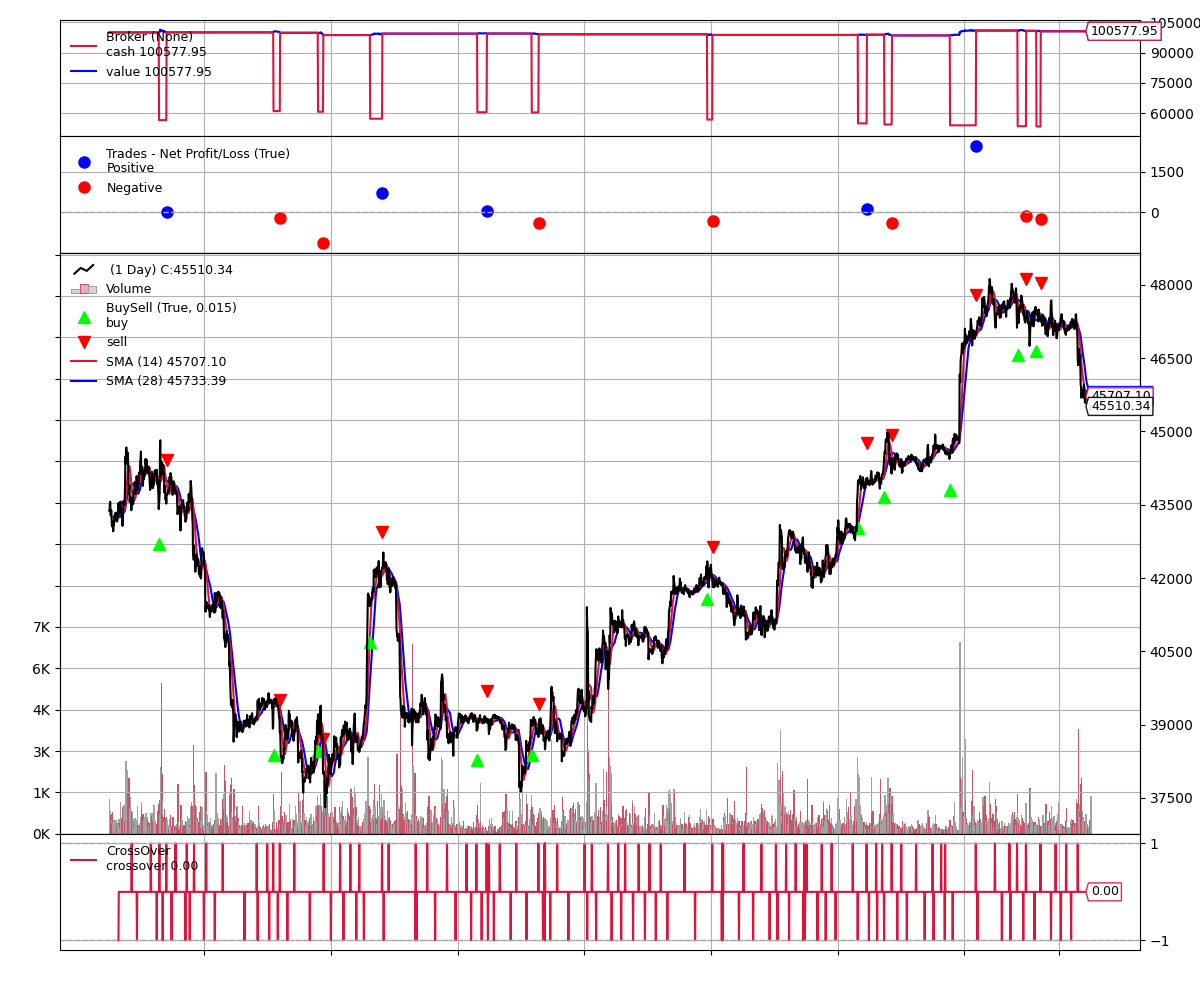

In [60]:
figure.savefig('backtest.png')

display.Image('backtest.png')